# Serial Code for Predicting Diabetes with the MIMIC III Dataset
---
### First import libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as ss
## install
!pip install imblearn
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import TomekLinks
from imblearn.metrics import specificity_score
from sklearn.model_selection import cross_validate
# from conditional_independence import partial_correlation_suffstat, partial_correlation_test
from sklearn.model_selection import KFold
import time
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    roc_auc_score
)
# from sklearn.naive_bayes import ComplementNB, MultinomialNB
from sklearn.naive_bayes import GaussianNB
from scipy.stats import multivariate_normal

import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn import svm

import warnings
warnings.filterwarnings('ignore')

### Produce filepaths

In [2]:
file_path = 'results.csv'
results = pd.read_csv(file_path)
# print(results)
file_path1 = 'titles.csv'
titles = pd.read_csv(file_path1)
# print(titles)

In [3]:
data = np.zeros((40000,35),dtype=object)
titles = np.array(titles)
results = np.array(results)

### Data preprocessing.

In [4]:
data[0,0],data[0,1],data[0,-1] = "SubjectID","Gender","Diabetes"
for i in range(2,34):
  data[0,i] = titles[i-2,0]

readrow = 0
i = 1
while(readrow < results.shape[0]):
# for i in range(1,data.shape[0]+1):
  count = 0
  for j in range(i-1,i+1):
    if(results[readrow,1]== data[j,0]):
      count = 1
      for k in range(2,34):
        if(results[readrow,2]==data[0,k]):
          data[j,k] = results[readrow,3]
  if (count==0):
    data[i,0] = results[readrow,1]
    data[i,1] = results[readrow,0]
    data[i,-1] = results[readrow,4]
    i += 1
    
  readrow += 1

### Extract Column Names and create a dataframe.

In [5]:
data = np.array(data)
data1 = data[0:35256,:]
print(data1[35255,:])
# Extract column names from the first row
column_names = data1[0,:]
# Create DataFrame using array and set column names
df = pd.DataFrame(data1[1:], columns=column_names)
# df1 = df.describe()
df

[99999 'F' 0 7.36 40.0 142.0 112.0 0 148.0 3.1 108.0 3.9 0.7 9.8 0 0 0 0 0
 15.0 0 0 0 0 0 0 139.0 0 104.0 5.1 0 0 0 0 1]


,SubjectID,Gender,51491,50820,50818,50983,50809,51478,50931,50813,...,50907,50824,51104,50806,50822,51099,50954,50905,50903,Diabetes
0,3,M,5.0,7.41,50.0,139.0,139.0,100.0,116.0,8.0,...,129.0,138.0,0,114.0,4.0,0,0,77.0,6.5,0
1,4,F,6.5,7.31,28.0,136.0,100.0,0,120.0,2.2,...,160.0,0,218.0,0,0,0.8,0,130.0,4.7,0
2,6,F,5.0,7.41,44.0,139.0,145.0,0,97.0,3.4,...,201.0,135.0,0,106.0,4.2,0.4,0,105.0,4.0,0
3,9,M,8.0,7.53,38.0,130.0,178.0,0,170.0,1.2,...,208.0,138.0,636.0,103.0,2.9,0,263.0,141.0,4.3,0
4,11,F,5.0,7.52,30.0,140.0,94.0,0,101.0,1.5,...,0,135.0,0,105.0,4.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35250,99985,M,5.5,7.39,41.0,136.0,0,0,151.0,2.1,...,165.0,0,0,0,0,0,184.0,87.0,3.5,0
35251,99991,M,5.5,7.42,35.0,143.0,0,0,138.0,1.3,...,0,0,0,0,0,0,0,0,0,1
35252,99992,F,5.0,0,0,136.0,0,0,123.0,0,...,0,0,0,0,4.6,0,0,0,0,0
35253,99995,F,6.0,7.59,33.0,139.0,110.0,0,131.0,1.5,...,0,132.0,0,94.0,4.1,0,0,0,0,1


### Data Cleaning

In [6]:
print("**************BEFORE DATA CLEANING**************")
des = np.array(df.describe())
print(des)

column_names = data1[0,:]

column_to_delete = [-2,-3,-4,-5]
df_clean = np.delete(df, column_to_delete, axis=1)
column_names = np.delete(column_names, column_to_delete)


column_to_delete = [7,20,23,27]
df_clean = np.delete(df_clean, column_to_delete, axis=1)
column_names = np.delete(column_names, column_to_delete)

column_to_delete = [17,19,20,21,22]
df_clean = np.delete(df_clean, column_to_delete, axis=1)
column_names = np.delete(column_names, column_to_delete)

column_to_delete = [14,15,16]
df_clean = np.delete(df_clean, column_to_delete, axis=1)
column_names = np.delete(column_names, column_to_delete)
print("**************AFTER DATA CLEANING**************")

df_clean = pd.DataFrame(df_clean,columns=column_names)
des = (df_clean.describe())
print(des)

**************BEFORE DATA CLEANING**************
[[35255 35255 35255.0 35255 35255 35255.0 35255 35255 35255.0 35255
  35255.0 35255 35255.0 35255 35255 35255 35255 35255 35255 35255.0 35255
  35255 35255 35255 35255 35255 35255 35255 35255 35255 35255 35255 35255
  35255 35255]
 [35255 2 10.0 103 136 70.0 571 9 541.0 278 73.0 83 147.0 174 168 197 1
  232 647 172.0 224 131 142 104 417 358 76 1304 84 99 147 1141 256 183 2]
 [3 'M' 5.0 0 0 139.0 0 0 104.0 0 103.0 0 0.8 0 0 0 0 0 0 14.0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0]
 [1 20139 11612.0 4729 5720 3662.0 11521 30501 528.0 7448 2803.0 5904
  4182.0 13852 12369 32852 35255 23845 23060 1551.0 29669 25611 25254
  28969 22372 24789 13643 27600 16973 9436 32207 24897 25814 25326 25560]]
**************AFTER DATA CLEANING**************
        SubjectID Gender    51491  50820  50818    50983  50809    50931  \
count       35255  35255  35255.0  35255  35255  35255.0  35255  35255.0   
unique      35255      2     10.0    103    136     70.0    571

In [7]:
# Count zeros in each row
df_clean_x = np.array(df_clean)[:,0:-1]
zero_counts = np.sum(df_clean_x == 0, axis=1)

# Find rows where the count is not zero
non_zero_rows = df_clean[zero_counts < 2]

# Display the result
# print(non_zero_rows)
data_clean1 = non_zero_rows 

### Standard Scalar

In [9]:
# Initialize the StandardScaler
scaler = StandardScaler()
data_clean1['Gender'] = LabelEncoder().fit_transform(data_clean1['Gender'])
y = data_clean1['Diabetes']
y = np.array(y,dtype = "int")
x = data_clean1.iloc[:, 1:-1].copy()

for i in range(2,19):
    for j in range(titles.shape[0]):
        if (column_names[i]==titles[j,0]):
            column_names[i] = titles[j,1]
            
x = np.array(x)
for i in range(1,x.shape[1]):
    for j in range(x.shape[0]):
        if(x[j,i]==0):
            x[j,i] = np.mean(x[:,i])
x = pd.DataFrame(x)
                        
xcolumn_names = ['Gender', 'pH1', 'pH2', 'pCO2', 'Sodium', 'Glucose1',
       'Glucose2', 'Lactate', 'Chloride', 'Potassium', 'Creatinine',
       'Hemoglobin1', 'Hemoglobin2', 'Urea Nitrogen', 'Sodium, Whole Blood',
       'Chloride, Whole Blood', 'Potassium, Whole Blood']
x.columns = xcolumn_names
x[['pH1', 'pH2', 'pCO2', 'Sodium', 'Glucose1',
       'Glucose2', 'Lactate', 'Chloride', 'Potassium', 'Creatinine',
       'Hemoglobin1', 'Hemoglobin2', 'Urea Nitrogen', 'Sodium, Whole Blood',
       'Chloride, Whole Blood', 'Potassium, Whole Blood']] = scaler.fit_transform(x[[ 'pH1', 'pH2', 'pCO2', 'Sodium', 'Glucose1',
       'Glucose2', 'Lactate', 'Chloride', 'Potassium', 'Creatinine',
       'Hemoglobin1', 'Hemoglobin2', 'Urea Nitrogen', 'Sodium, Whole Blood',
       'Chloride, Whole Blood', 'Potassium, Whole Blood']])

print('Original dataset shape:\n', pd.value_counts(y))
x

Original dataset shape:
 0    9735
1    4291
Name: count, dtype: int64


,Gender,pH1,pH2,pCO2,Sodium,Glucose1,Glucose2,Lactate,Chloride,Potassium,Creatinine,Hemoglobin1,Hemoglobin2,Urea Nitrogen,"Sodium, Whole Blood","Chloride, Whole Blood","Potassium, Whole Blood"
0,1,-0.966730,0.310107,0.913922,0.087789,-0.077189,-0.257266,2.753935,-0.168093,0.163428,0.142034,-1.408888,-1.388311,0.588544,0.194642,1.477595,-0.212923
1,0,-0.966730,0.310107,0.288053,0.087789,0.017416,-0.594744,0.533059,1.030783,3.590391,2.229613,-0.927759,-1.388024,-0.480670,-0.421766,0.181948,0.043535
2,1,2.274994,1.742915,-0.337816,-1.908610,0.537745,0.701881,-0.529099,-1.024433,-0.913722,-0.089919,1.477883,1.665926,-0.277010,0.194642,-0.303919,-1.623444
3,0,-0.966730,1.623514,-1.172308,0.309611,-0.786728,-0.523696,-0.384259,-0.168093,-0.913286,-0.476508,0.515626,1.233020,-0.633415,-0.421766,0.019992,-0.212923
4,1,-0.966730,0.787710,-0.024881,1.862367,-0.376772,-0.754602,2.126296,-1.024433,-1.550053,0.296669,-1.365149,-1.387736,0.333969,0.811051,1.639551,-0.084694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14021,0,-0.966730,0.668309,-0.000307,-0.134033,-0.644820,-0.008599,-0.335979,1.373319,0.334776,-0.244555,1.390405,1.124794,-0.124265,0.811051,-0.303919,0.428223
14022,1,-0.966730,0.190707,-1.589555,-1.686788,-0.408307,1.447884,-0.384259,-2.052040,-0.350616,-0.321872,-0.577848,0.204869,-0.633415,-2.065523,-0.303919,0.941140
14023,1,-0.966730,0.310107,0.183742,4.080588,2.366777,1.252502,-0.287699,0.003175,-0.000501,0.219352,0.909277,0.908341,0.028480,-1.654584,1.963463,-0.982298
14024,1,0.113844,0.071306,-1.067997,-0.355855,-0.928635,-0.203980,0.098540,0.174443,-0.350616,-0.321872,-0.009241,-0.000387,-0.022435,-0.421766,-0.789787,-0.469381


In [10]:
# type(data_clean1)
# x = data_clean1.iloc[:, :-1].copy()
# x

In [11]:
# Export Pandas DataFrame to CSV
csv_filename = "cleanData.csv"
data_clean1.to_csv(csv_filename, index=False)

### Resample dataset to make the shape/size evenly distributed

In [12]:
from imblearn.over_sampling import RandomOverSampler

# resample=SMOTETomek(sampling_strategy="auto",random_state = 2)
resample = RandomOverSampler(sampling_strategy='auto', random_state=42)
# resample = SMOTE(sampling_strategy='all',random_state = 2)
# resample = SMOTEENN(sampling_strategy='all', random_state = 2)
x_bal, y_bal = resample.fit_resample(x, y)
print('After resampling the dataset shape is:\n', pd.value_counts(y_bal))
x_tl, x_tl_test, y_tl, y_tl_test = train_test_split(x_bal, y_bal, test_size=0.2, random_state=42)

balanceData = pd.concat([pd.DataFrame(x_bal), pd.DataFrame(y_bal)], axis=1)
column_names_ = ['Gender', 'pH1', 'pH2', 'pCO2', 'Sodium', 'Glucose1',
       'Glucose2', 'Lactate', 'Chloride', 'Potassium', 'Creatinine',
       'Hemoglobin1', 'Hemoglobin2', 'Urea Nitrogen', 'Sodium, Whole Blood',
       'Chloride, Whole Blood', 'Potassium, Whole Blood','label']
balanceData.columns = column_names_


After resampling the dataset shape is:
 0    9735
1    9735
Name: count, dtype: int64


In [13]:
csv_filename = "balancData.csv"
balanceData.to_csv(csv_filename, index=False)


### Defining functions to be used in model predicting/evaluation.

In [14]:
def cv_(model,kfold,X,Y):
    
    kf = KFold(n_splits=kfold, shuffle = True, random_state = 0)

    accuracy = np.zeros(kfold)
    precision = np.zeros(kfold)
    recall  = np.zeros(kfold)
    f1 = np.zeros(kfold)
    roc_auc = np.zeros(kfold)
    specificity = np.zeros(kfold)
    

    j = int(0)
    
    for train_index , test_index in kf.split(X): 

        N = len(train_index)
        n = len(test_index)
        X_tr = np.zeros((N,19))
        Y_tr = np.zeros(N)
        X_te = np.zeros((n,19))
        Y_te = np.zeros(n)
        for i in range(N):
            X_tr[i] = X[train_index[i]]
            Y_tr[i] = Y[train_index[i]]
        for i in range(n):
            X_te[i] = X[test_index[i]]
            Y_te[i] = Y[test_index[i]]

        Y_pre =model.fit(X_tr, Y_tr).predict(X_te)
        accuracy[j] = accuracy_score(Y_te, Y_pre)
        f1[j] = f1_score(Y_te, Y_pre,average="weighted")
        precision[j] = precision_score(Y_te, Y_pre,average="weighted")
        recall[j] = recall_score(Y_te, Y_pre,average="weighted")
        roc_auc[j] = roc_auc_score(Y_te, Y_pre,average="weighted")
        specificity[j] = specificity_score(Y_te, Y_pre,average="weighted")
        j = j+1
        
    print("CV Accuray: ", accuracy.mean().round(4))
    print("CV Precision: ", precision.mean().round(4))
    print("CV Recall: ", recall.mean().round(4))
    print("CV specificity: ", specificity.mean().round(4))
    print("CV f1-score: ", f1.mean().round(4))
    print("CV roc_auc score: ", roc_auc.mean().round(4))
    return accuracy.mean(),precision.mean(),recall.mean(),specificity.mean(),f1.mean(),roc_auc.mean()
    
def plot_confusion(y,y_pred):
    plt.rc('xtick', labelsize=10)  
    plt.rc('ytick', labelsize=10)
    c_m = confusion_matrix(y, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = c_m, display_labels = ['Positive', 'Negative'])
    cm_display.plot()
    plt.title("Model")
    plt.show()

def predict_score(model,x,y):
    np.random.seed(22)

    start1 = time.time()
    ypre = model.predict(x)
    end1 = time.time()
    runtime = end1 - start1
    print("The model predicting time: ", runtime)
    
    accuray = accuracy_score(y, ypre)
    f1 = f1_score(y, ypre,average="weighted")
    precision = precision_score(y, ypre,average="weighted")
    recall = recall_score(y, ypre,average="weighted")
    # roc_auc = roc_auc_score(y, ypre,average="weighted")
    specificity = specificity_score(y, ypre,average="weighted")
    print("Predict on x (Accuray): ", accuray.round(4))
    print("Predict on x (Precision): ",precision.round(4))
    print("Predict on x (Recall): ", recall.round(4))
    print("Predict on x (specificity): ", specificity.round(4))
    print("Predict on x (f1-score): ", f1.round(4))
    # print("Predict on x (roc_auc-score): ", roc_auc.round(4))
    
    plot_confusion(y,ypre)

def search_para(model, cv, grid, x, y):
    search = GridSearchCV(model, grid, scoring='f1_weighted', cv=cv, n_jobs=-1)
    results = search.fit(x, y)
    print('Mean f1-score: %.4f' % results.best_score_)
    print('Config: %s' % results.best_params_)
    

In [15]:

# import warnings
# warnings.filterwarnings('ignore')
# # define model, cv, grid
# model_logit = LogisticRegression(max_iter=100000,random_state=69)
# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
# grid = {'solver':('lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga'), 'C':[10,100,1000,10000]}



# print("------x_tl, y_tl-----------")
# search_para(model_logit, cv, grid, x_tl, y_tl)

### Logistic Regression

----------x_tl, y_tl-----------
Logistic regression model fitting time:  0.03977203369140625
-------------
The model predicting time:  0.01089620590209961
Predict on x (Accuray):  0.6831
Predict on x (Precision):  0.6872
Predict on x (Recall):  0.6831
Predict on x (specificity):  0.6833
Predict on x (f1-score):  0.6814


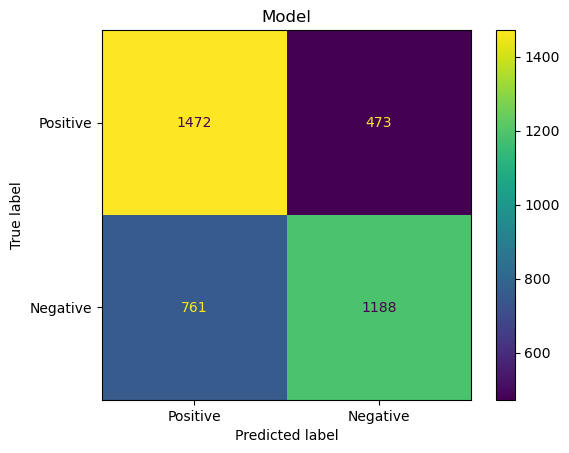

In [16]:
kfold = 5

x_tl = pd.DataFrame(x_tl).values
x = pd.DataFrame(x).values


print("----------x_tl, y_tl-----------")

# model fitting run time
start1 = time.time()
# model_logit = LogisticRegression(solver = 'liblinear', C = 100, max_iter=100000,random_state=6)
model_logit = LogisticRegression(solver = 'lbfgs', max_iter = 100, tol = 1e-06, random_state=6)
model_logit_fit = model_logit.fit(x_tl, y_tl)
end1 = time.time()
runtime = end1 - start1
print("Logistic regression model fitting time: ", runtime)
print("-------------")
predict_score(model_logit_fit,x_tl_test,y_tl_test)


In [17]:
# define model, cv, grid

# import warnings
# warnings.filterwarnings("ignore", category=DeprecationWarning)

# svm_soft = svm.LinearSVC(dual = False, max_iter = 100000000, random_state=1)
# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
# grid = {'multi_class': ('ovr', 'crammer_singer'),'loss':('hinge', 'squared_hinge'), 'tol':[1e-2,1e-3, 1e-4], 'C':[1e-1,1e-2,1e-3,1e-5,1e-10],'intercept_scaling':[0.01,0.1,1,10]}


# print("------x_tl, y_tl-----------")
# search_para(svm_soft, cv, grid, x_tl, y_tl)


### SVM

------x_tl, y_tl-----------
SVM model fitting time:  1.0607490539550781
-------------
The model predicting time:  0.0073468685150146484
Predict on x (Accuray):  0.6875
Predict on x (Precision):  0.6931
Predict on x (Recall):  0.6875
Predict on x (specificity):  0.6876
Predict on x (f1-score):  0.6852


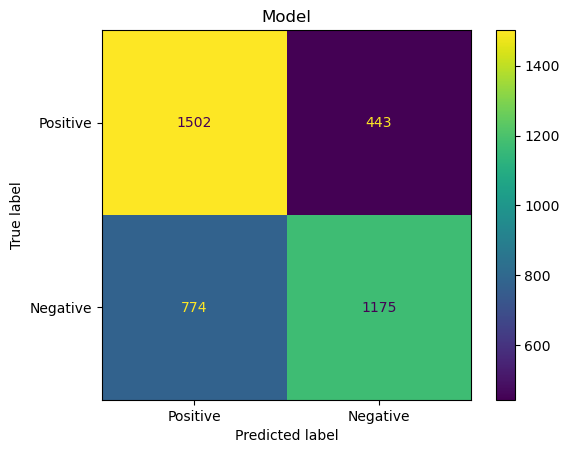

In [18]:
kfold = 5
x_tl = pd.DataFrame(x_tl).values
x = pd.DataFrame(x).values

print("------x_tl, y_tl-----------")
start1 = time.time()
# svm_soft = svm.LinearSVC(loss ='squared_hinge',tol = 0.01,
#                           intercept_scaling = 0.01, 
#                           multi_class = 'ovr',
#                           C = 0.1, max_iter=1000000000,random_state=1)
svm_soft = svm.LinearSVC(random_state=1)
# model fitting run time
svm_soft_fit = svm_soft.fit(x_tl,y_tl)
end1 = time.time()
runtime = end1 - start1
print("SVM model fitting time: ", runtime)
print("-------------")
predict_score(svm_soft_fit,x_tl_test,y_tl_test)